<a href="https://colab.research.google.com/github/Venura-Shiromal/NASA-Space-Apps-2025/blob/main/K2_ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisities

In [35]:
# just in case if needed
# !pip install catboost

In [36]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [37]:
k2 = pd.read_csv('sample_data/k2pandc_2025.09.26_11.17.56.csv', comment='#')
k2.head()

,pl_name,hostname,default_flag,disposition,disp_refname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,BD+20 594 b,BD+20 594,0,CONFIRMED,Espinoza et al. 2016,1.0,1.0,Transit,2016.0,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2018-03,2018-02-15
1,BD+20 594 b,BD+20 594,0,CONFIRMED,Espinoza et al. 2016,1.0,1.0,Transit,2016.0,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2016-10,2016-07-28
2,BD+20 594 b,BD+20 594,1,CONFIRMED,Espinoza et al. 2016,1.0,1.0,Transit,2016.0,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2017-03,2018-04-26
3,EPIC 201111557.01,EPIC 201111557,1,CANDIDATE,Livingston et al. 2018,1.0,0.0,Transit,2018.0,K2,...,-0.046,9.220,0.019,-0.019,11.3995,0.001307,-0.001307,2018-08-02,2018-08,2018-08-02
4,EPIC 201111557.01,EPIC 201111557,0,CANDIDATE,Livingston et al. 2018,1.0,0.0,Transit,2018.0,K2,...,-0.046,9.220,0.019,-0.019,11.3995,0.001307,-0.001307,2018-02-15,2018-03,2018-02-15


## Feature Selection

In [38]:
features = [
    "pl_orbper",
    "pl_orbsmax",
    "pl_rade",
    "pl_radj",
    "pl_bmasse",
    "pl_bmassj",
    "pl_orbeccen",
    "pl_insol",
    "pl_eqt",
    "st_teff",
    "st_rad",
    "st_mass",
    "st_met",
    "st_logg",

    "disposition",

    "discoverymethod",
    "disc_year",
    "sy_dist",
    "st_spectype"
]

Label Mapping

In [39]:
label_map = {
    'CONFIRMED': 1,   # Confirmed Planet
    'CANDIDATE': 0,   # Planetary Candidate
    'FALSE POSITIVE': -1,  # False Positive
    'REFUTED': -1   # False Alarm
}

method_map = {
    'Transit': 2,
    'Radial Velocity': 1,
    'Microlensing': 0
}

spectral_map = {
    'K3': 0, 'G': 1, 'G8': 2, 'K5': 3, 'K0': 4, 'K2': 5, 'M4': 6, 'F8': 7, 'K7': 8,
    'G2': 9, 'G3': 10, 'F0': 11, 'G5': 12, 'G7': 13, 'G1': 14, 'G9': 15, 'M0': 16,
    'G0': 17, 'M3': 18, 'K4': 19, 'G4': 20, 'F2': 21, 'F7': 22, 'G5 V': 23, 'M5': 24,
    'M2': 25, 'M1': 26, 'A III': 27, 'F5 V': 28, 'F5': 29, 'F9': 30, 'F6': 31, 'G6': 32,
    'G8 IV/V': 33, 'M2.5 V': 34, 'K6 V': 35, 'K7 V': 36, 'K5 V': 37, 'F': 38, 'G0 V': 39,
    'G V': 40, 'K0 V': 41, 'F6 V': 42, 'K1': 43, 'F9 IV': 44, 'K3 V': 45, 'M1.0 V': 46,
    'M1.5 V': 47, 'M1 V': 48, 'K5.5': 49, 'M3 V': 50, 'G8 V': 51, 'K1 V': 52, 'G6 V': 53,
    'M3.0 V': 54, 'M0.0 V': 55, 'G9 V': 56, 'K2 V': 57, 'M0.0': 58, 'M0 V': 59, 'F9 V': 60,
    'G2 V': 61, 'M0.5 V': 62, 'M4.5': 63, 'M4.5 V': 64, 'G7 IV/V': 65, 'G7 V': 66, 'G3 V': 67,
    'M V': 68, 'M0.0&plusmn;0.5 V': 69, 'M(3.5+/-0.5) V': 70, 'M3.3': 71, 'K4 V': 72,
    'M4 V': 73, 'M5 V': 74, 'K7.5 V': 75, 'G4 V': 76, 'M3.0': 77, 'F8 V': 78, 'G0 IV': 79,
    'K6': 80, 'K3.5 V': 81
}

k2["disposition"] = k2["disposition"].map(label_map)
k2["discoverymethod"] = k2["discoverymethod"].map(method_map)
k2['st_spectype'] = k2['st_spectype'].map(spectral_map)

In [40]:
k2 = k2[features]

## Filling empty cells

In [41]:
numerical_cols = [
    "pl_orbper", "pl_orbsmax", "pl_rade", "pl_radj",
    "pl_bmasse", "pl_bmassj", "pl_orbeccen", "pl_insol", "pl_eqt",
    "st_teff", "st_rad", "st_mass", "st_met", "st_logg",
    "sy_dist", "discoverymethod", "st_spectype", "disc_year"
]

for col in numerical_cols:
    k2[col].fillna(k2[col].median(), inplace=True)

/tmp/ipython-input-774407731.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  k2[col].fillna(k2[col].median(), inplace=True)


### Checking if NaN available

In [42]:
print(k2.isna().sum())

pl_orbper          0
pl_orbsmax         0
pl_rade            0
pl_radj            0
pl_bmasse          0
pl_bmassj          0
pl_orbeccen        0
pl_insol           0
pl_eqt             0
st_teff            0
st_rad             0
st_mass            0
st_met             0
st_logg            0
disposition        0
discoverymethod    0
disc_year          0
sy_dist            0
st_spectype        0
dtype: int64


## Defining data sets

In [43]:
X = k2.drop("disposition", axis=1)
y = k2["disposition"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

Defining Classes

In [45]:
classes = np.unique(y_train)

Calculating Class Weights

In [46]:
weights = compute_class_weight("balanced", classes=classes, y=y_train)

Combining both

In [47]:
class_weights = dict(zip(classes, weights))

### Cross-validation

In [48]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in skf.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

## Cat Boost Initiation

### Parameters


In [49]:
max_ite = 2500
dep = 8
l_rate = 0.01

In [50]:
model = CatBoostClassifier(
    iterations=max_ite,
    depth=dep,
    learning_rate=l_rate,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    l2_leaf_reg=7,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=50,
    class_weights=class_weights
)


# Training

In [51]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 1.0942781	test: 1.0941535	best: 1.0941535 (0)	total: 77.4ms	remaining: 3m 13s
50:	learn: 0.9203142	test: 0.9179597	best: 0.9179597 (50)	total: 1.54s	remaining: 1m 14s
100:	learn: 0.8158506	test: 0.8109367	best: 0.8109367 (100)	total: 2.98s	remaining: 1m 10s
150:	learn: 0.7438599	test: 0.7367301	best: 0.7367301 (150)	total: 4.39s	remaining: 1m 8s
200:	learn: 0.6943376	test: 0.6864639	best: 0.6864639 (200)	total: 5.82s	remaining: 1m 6s
250:	learn: 0.6556171	test: 0.6471722	best: 0.6471722 (250)	total: 7.63s	remaining: 1m 8s
300:	learn: 0.6249105	test: 0.6157788	best: 0.6157788 (300)	total: 9.73s	remaining: 1m 11s
350:	learn: 0.5985289	test: 0.5892285	best: 0.5892285 (350)	total: 11.2s	remaining: 1m 8s
400:	learn: 0.5751741	test: 0.5657992	best: 0.5657992 (400)	total: 12.6s	remaining: 1m 5s
450:	learn: 0.5557584	test: 0.5469950	best: 0.5469950 (450)	total: 14s	remaining: 1m 3s
500:	learn: 0.5391731	test: 0.5306593	best: 0.5306593 (500)	total: 15.4s	remaining: 1m 1s
550:	learn: 0

### Plotting Loss

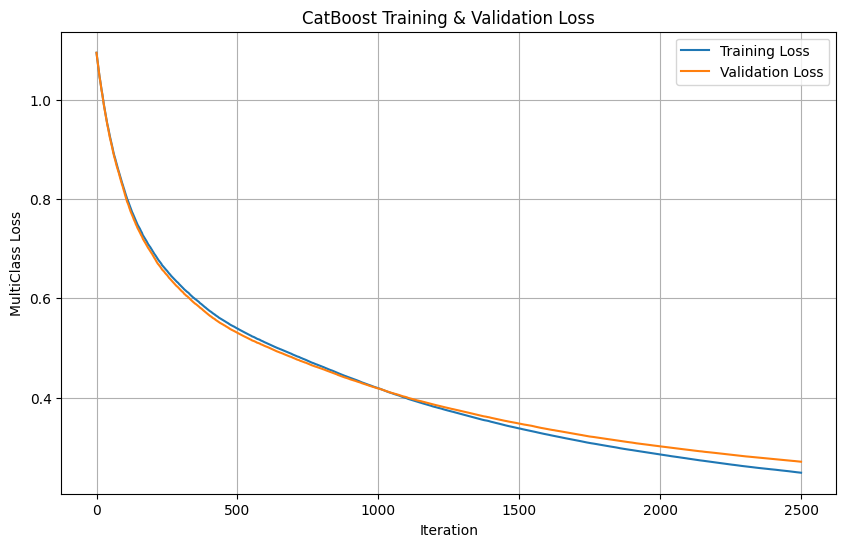

In [52]:
evals_result = model.get_evals_result()

train_loss = evals_result['learn']['MultiClass']
valid_loss = evals_result['validation']['MultiClass']

plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('CatBoost Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [53]:
y_pred = model.predict(X_test)

### Confusion Matrix

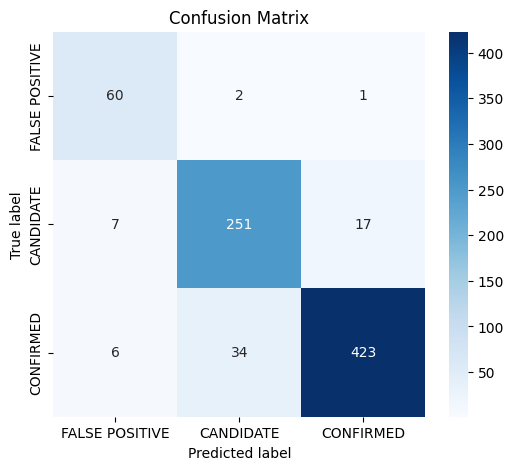

In [54]:
cm = confusion_matrix(y_test, y_pred)

class_names = ["FALSE POSITIVE", "CANDIDATE", "CONFIRMED"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Accuracy

In [55]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 91.64%
